In [1]:
import matplotlib.pyplot as plt

# NOTEBOOK UNDER CONSTRUCTION
## Differentiable Feedback Delay Network for Colorless Reverberation 
Presented at the 26th International Conference on Digital Audio Effects (DAFx23), Copenhagen, Denmark, 4 - 7 September 2023  

Authors: Gloria Dal Santo, Karolina Prawda, Sebastian J. Schlecht, and Vesa Välimäki (Aalto University Acoustics Lab)  
Date created: 22.08.23  
Last modified: 22.08.23  


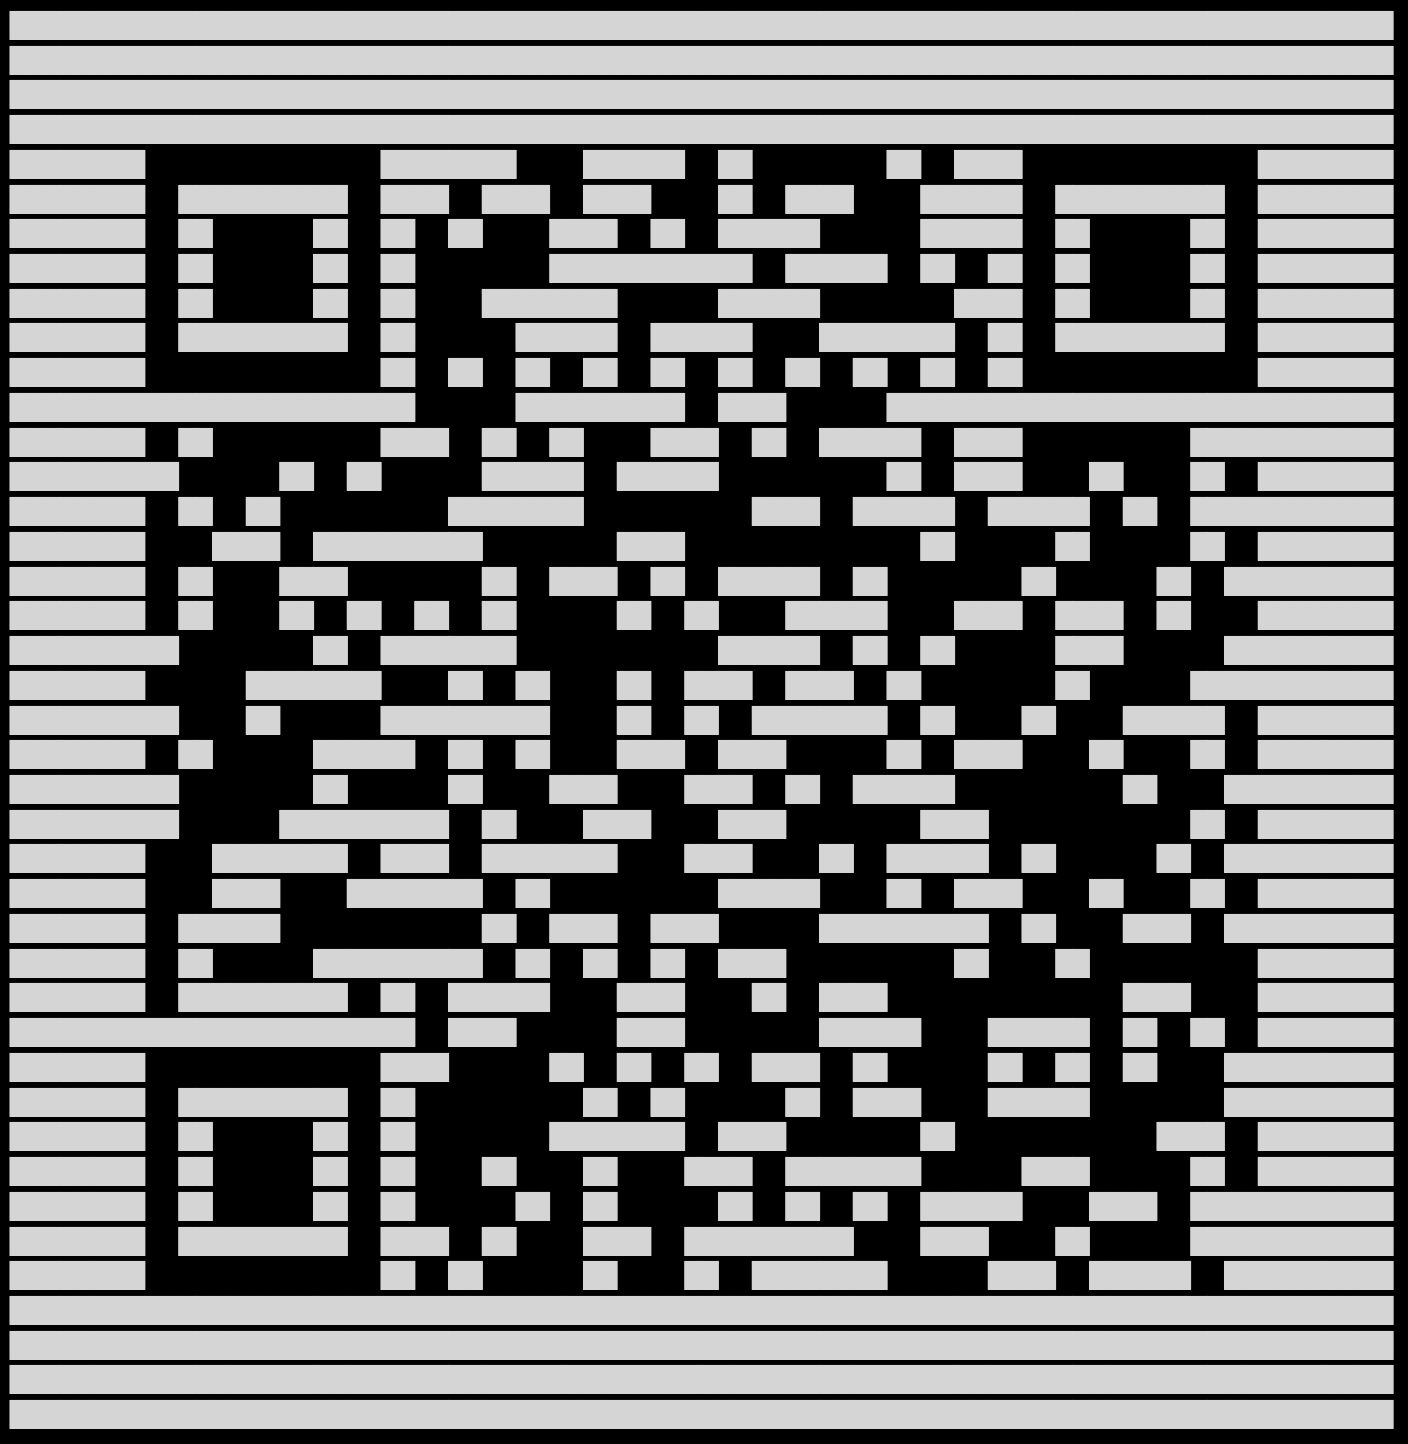

In [2]:
from IPython.display import Image, display
display(Image(filename='demo/qr_code_github.png', width=128, height=128))

### Feedback Delay Network
An FDN is a recursive system consisting of delay lines, a set of gains, and a scalar feedback matrix through which the delay outputs are coupled to the delay inputs. 

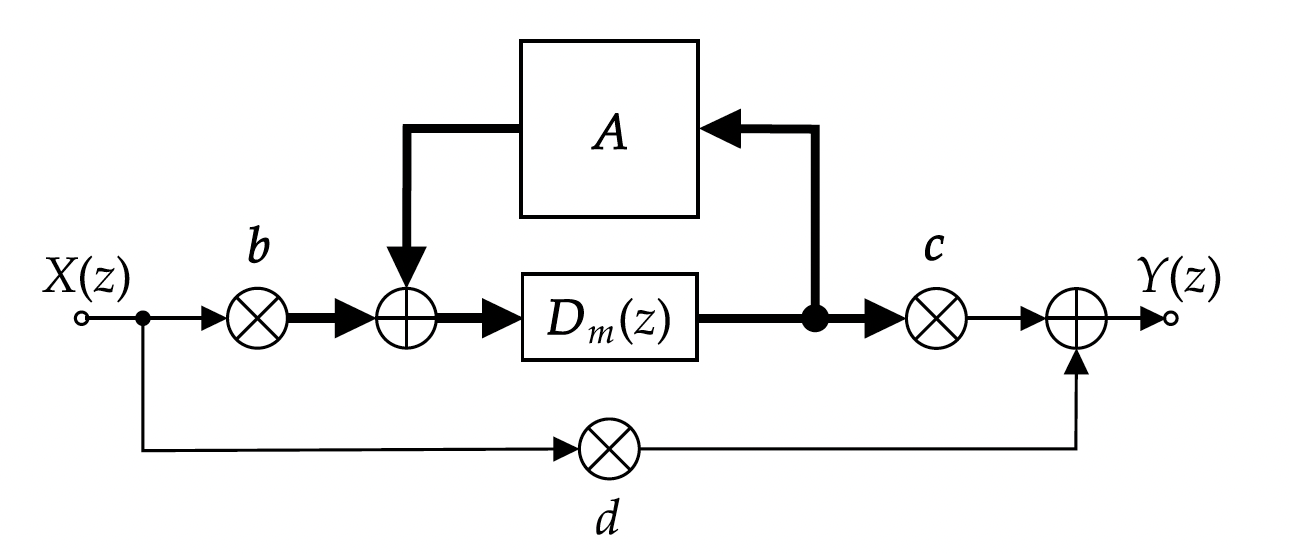

In [3]:
display(Image(filename='demo/fdn_blockdiagram.png', width=512, height=512))

FDN Transfer Function  
$H(z) = \mathbf{c}^\top\big[\mathbf{D_m}(z)^{-1} -\mathbf{A}\big]^{-1}\mathbf{b} + d$   
Partial Fraction Decomposition  
$H(z) = d + \sum_{i=1}^\N\frac{\rho_i}{1-\lambda_iz^{-1}}$

#### Dataset 
This work applies the frequency-sampling method to approximate an FDN as a finite-impulse-response (FIR) filter.  
This is done by evaluating the delay matrix in the transfer function, $\mathbf{D_m(\bar{z}_M)}$, at the discrete frequency points in the vector  
$\vec{z}_M = [e^{\jmath \pi \frac{0}{M}}, e^{\jmath \pi \frac{1}{M}}, \dots, e^{\jmath \pi \frac{M-1}{M}}]$  

The dataset consists of vectors of frequency points, equally distributed on the unit circle, with different length $M$. In this way, at every training step $H(z)$ is computed on a different set of frequency points. 


Generating dataset: 100%|██████████| 256/256 [00:00<00:00, 110353.73it/s]


Text(0, 0.5, 'Imag')

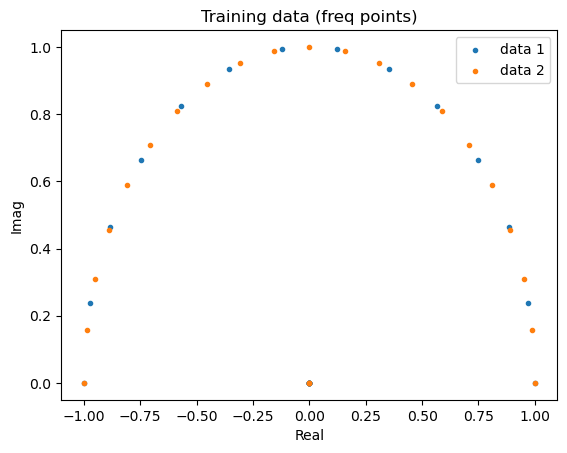

In [4]:
import torch 
from solver import *
import demo.args as args   

# set low value of nfft just for illustrative puproses
args.max_nfft = 24
args.min_nfft = 12

# load training and validation dataset
train_dataset, valid_dataset = load_dataset(args)

train_ex, _ = next(iter(train_dataset))
plt.scatter(torch.real(train_ex[0,:]), torch.imag(train_ex[0,:]), marker=".",  label='data 1')
plt.scatter(torch.real(train_ex[2,:]), torch.imag(train_ex[2,:]), marker=".",  label='data 2')
plt.legend()
plt.title("Training data (freq points)")
plt.xlabel("Real")
plt.ylabel("Imag")

In [8]:
# restore nfft original values 
args.max_nfft, args.min_nfft = 480000, 384000
# load full dataset 
train_dataset, valid_dataset = load_dataset(args)
# load model 
net = DiffFDN(args.delays, args.gain_per_sample, args.device)
# training configuration 
optimizer = torch.optim.Adam(net.parameters(), lr=args.lr) 
criterionFreq = asy_p_loss()        # spectral loss
criterionTime = sparsity_loss()     # temporal loss 
# energy normalization through input and output gains
x = get_frequency_samples(args.max_nfft)
with torch.no_grad():
    H = get_response(x, net)[0].squeeze()
    energyH = torch.mean(torch.pow(torch.abs(H),2))
    # apply energy normalization on input and output gains only
    net.B.data.copy_(torch.div(net.B, torch.pow(energyH, 1/4)))
    net.C.data.copy_(torch.div(net.C, torch.pow(energyH, 1/4)))

# ----------- TRAINING LOOP
# train_loss
train_loss, valid_loss = [], []
st = time.time()     

for epoch in range(args.max_epochs):
    epoch_loss = 0
    st_epoch = time.time()

    for i, data in enumerate(train_dataset):
        # batch processing
        inputs, labels = data 
        optimizer.zero_grad()
        H, h, param = net(inputs)
        loss = criterionFreq(H, labels) + args.alpha*criterionTime(torch.abs(h), torch.ones(h.size(-1)))

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss.append(epoch_loss/len(train_dataset))

    # validation
    epoch_loss = 0
    for i, data in enumerate(valid_dataset):
        inputs, labels = data
        
        optimizer.zero_grad()
        H, h, _ = net(inputs)
        loss = criterionFreq(H, labels) + args.alpha*criterionTime(torch.abs(h), torch.ones(480000))
        
        epoch_loss += loss.item()
    
    valid_loss.append(epoch_loss/len(valid_dataset))
    et_epoch = time.time()
    to_print = get_str_results(
        epoch=epoch, 
        train_loss=train_loss, 
        valid_loss=valid_loss, 
        time=et_epoch-st_epoch)
    print(to_print)

# end time 
et = time.time()    
print('Training time: {:.3f}s'.format(et-st))

Generating dataset: 100%|██████████| 256/256 [00:00<00:00, 3799.58it/s]


tensor(3.5919e-07, grad_fn=<DistBackward0>)


#### Loss function 
$\mathcal{L} = \mathcal{L}_\textrm{spectral}(\hat{\boldsymbol{H}}(\bar{z}_{M})) +\alpha \mathcal{L}_\textrm{temporal}(\hat{h})$  
$\mathcal{L} = \frac{1}{K} \sum_{i = 1}^N \sum_{k = 1}^K({{|\hat{H}_i(\bar{z}_{M}[k])|}-1})^p + \alpha \frac{||{\hat{h}}||_2}{||{\hat{h}}||_1}$

TODO: 
plot loss curve
show evolution of the parameters 
show modal excitation distribution 
